https://www.kaggle.com/charel/learn-by-example-rnn-lstm-gru-time-series

https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks



In [0]:
#For reproducable results on CPU:
#from numpy.random import seed
#seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)
#!pip uninstall tensorflow
#!pip3 install --upgrade tensorflow-gpu==1.4

import numpy as np 
from numpy import newaxis
import pandas as pd 
from keras.layers import Dense, Activation, Dropout
from keras.layers import CuDNNLSTM, CuDNNGRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


Using TensorFlow backend.


In [0]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation). 
# So by design these networks are deep/long to catch recurrent patterns.
Enrol_window = 60

print ('enrol window set to',Enrol_window )

enrol window set to 60


In [0]:
sc = MinMaxScaler(feature_range=(0,1))
def load_data(datasetname, column, seq_len, normalise_window):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

  
def normalise_windows(window_data):
    # A support function to normalize a dataset
    # Normalise window with a base value of zero
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs
  
  
  
def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [0]:
# Recurrent Neural Network

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
!curl https://raw.githubusercontent.com/muke888/UdemyDeepLearning/master/3.%20Recurrent%20Neural%20Networks/Google_Stock_Price_Train.csv -o Google_Stock_Price_Train.csv
!curl https://raw.githubusercontent.com/muke888/UdemyDeepLearning/master/3.%20Recurrent%20Neural%20Networks/Google_Stock_Price_Test.csv -o Google_Stock_Price_Test.csv
  
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv',index_col='Date', parse_dates=['Date'], thousands=',') 
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv', index_col='Date', parse_dates=['Date'], thousands=',')
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
print(dataset_total.shape)
print(dataset_total.dtypes)
dataset_total.tail()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63488  100 63488    0     0   183k      0 --:--:-- --:--:-- --:--:--  183k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1029  100  1029    0     0   3396      0 --:--:-- --:--:-- --:--:--  3396
(1278, 5)
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


,Open,High,Low,Close,Volume
Date,,,,,
2017-01-25,829.62,835.77,825.06,835.67,1494500
2017-01-26,837.81,838.00,827.01,832.15,2973900
2017-01-27,834.71,841.95,820.44,823.31,2965800
2017-01-30,814.66,815.84,799.80,802.32,3246600
2017-01-31,796.86,801.25,790.52,796.79,2160600


For stock price normalization, instead of range(0,1) we will take each n-sized window of training/testing data and normalize each one to reflect percentage changes from the start of that window (so the data at point i=0 will always be 0). We'll use the following equations to normalize and subsequently de-normalize at the end of the prediction process to get a real world number out of the prediction:


n = normalized list [window] of price changes

p = raw list [window] of adjusted daily return prices

Normalization : n_i = (p_i/n_0)-1

De-Normalization: p_i = p_0(n_i +1)

Set result = sc.fit_transform(result) in Load_data function to switch normalization methods

In [0]:
X_train, y_train, X_test, y_test = load_data(dataset_total, "Close", Enrol_window, True)
new=dataset_total.reset_index()

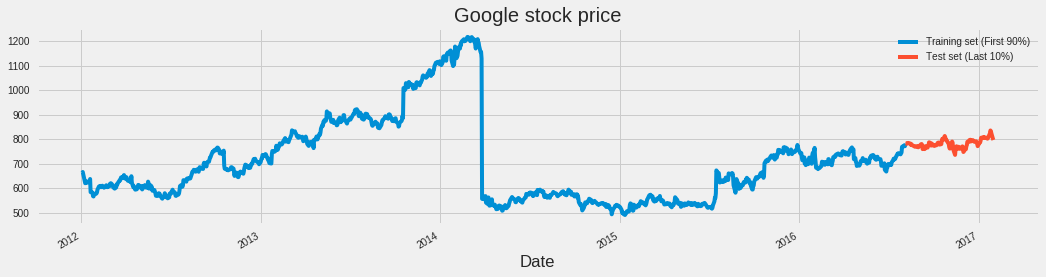

In [0]:
dataset_total["Close"][:new.iloc[(new.shape[0]-X_test.shape[0]-1),0]].plot(figsize=(16,4),legend=True)
dataset_total["Close"][new.iloc[(new.shape[0]-X_test.shape[0]-1),0]:].plot(figsize=(16,4),legend=True) # 10% is used for test
plt.legend(['Training set (First 90%)','Test set (Last 10%)'])
plt.title('Google stock price')
plt.show()

In [0]:
# Note: replace LSTM with GRU or RNN if you want to try those
#CuDNNGRU

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(CuDNNGRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(CuDNNGRU(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(CuDNNGRU(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(CuDNNGRU(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer, linear activation is default when not specified
regressor.add(Dense(units = 1, activation = "linear"))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 300, batch_size = 32, verbose=1,
          validation_data=(X_test, y_test))

Train on 1095 samples, validate on 122 samples
Epoch 1/300
1095/1095 [==============================] - 6s 6ms/step - loss: 0.0061 - val_loss: 3.1657e-04
Epoch 2/300
1095/1095 [==============================] - 2s 2ms/step - loss: 0.0027 - val_loss: 2.9370e-04
Epoch 3/300
1095/1095 [==============================] - 2s 2ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 4/300
1095/1095 [==============================] - 2s 2ms/step - loss: 0.0024 - val_loss: 5.4479e-04
Epoch 5/300
1095/1095 [==============================] - 2s 2ms/step - loss: 0.0019 - val_loss: 2.2220e-04
Epoch 6/300
1095/1095 [==============================] - 2s 2ms/step - loss: 0.0019 - val_loss: 6.2659e-04
Epoch 7/300
1095/1095 [==============================] - 2s 2ms/step - loss: 0.0019 - val_loss: 2.1401e-04
Epoch 8/300
1095/1095 [==============================] - 2s 2ms/step - loss: 0.0019 - val_loss: 2.4013e-04
Epoch 9/300
1095/1095 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 1.990

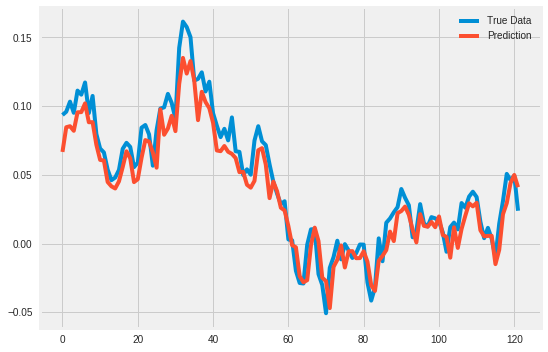

In [0]:
#Point by point prediction
#Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time, yielding better performance


predicted_stock_price = regressor.predict(X_test)
plot_results(predicted_stock_price,y_test)

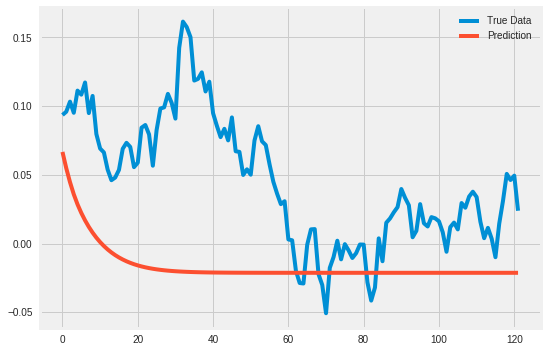

In [0]:
#Full sequence prediction
predicted_stock_price = predict_sequence_full(regressor, X_test, Enrol_window)
plot_results(predicted_stock_price,y_test)

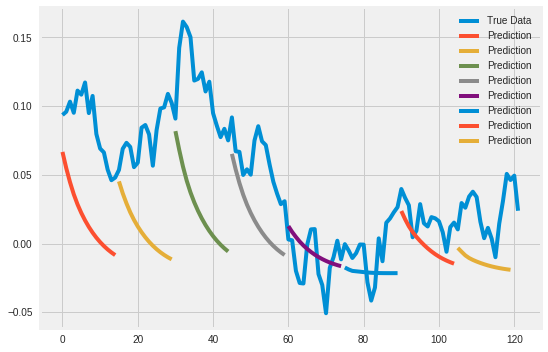

In [0]:
'''Lastly we have multi-sequence prediction. This is a blend of the full 
sequence prediction in the sense that it still initializes the testing window
with test data, predicts the next point over that and makes a new window with 
the next point. However, once it reaches a point where the input window is made
up fully of past predictions it stops, shifts forward one full window length, 
resets the window with the true test data, and starts the process again. In 
essence this gives multiple trend-line like predictions over the test data to 
be able to analyze how well the model can pick up future momentum trends.

Below we predict a new point based on the actual last 60 points,
the next point on 59 actual points and 1 prediction,
the next point on 58 actuals and 2 predictions, etc.
#Lets make 15 predictions ahead in the future and do this 
every 15 times to get a bearing how the model predicts
'''

predicted_stock_price = predict_sequences_multiple(regressor, X_test, Enrol_window, 15)
plot_results_multiple(predicted_stock_price, y_test, 15) 